# Chapter 11: Training deep neural networks

- Common problems and solutions with training deep networks at a glance: <br>

| Problem                       | Solution                                                                                  |
| :---------------------------- | :---------------------------------------------------------------------------------------- |
| Vanishing/exploding gradients | [Different initialization](#solution-1-glorot-he-and-lecun-initialization), activation functions, batch normalization and gradient clipping |
| Limited data                  | [Transfer learning](#solution-1-reusing-pretrained-layers-transfer-learning) and [unsupervised learning](#solution-2-use-unsupervised-learning-or-pretraining)                                              |
| Slow training                 | [Use of different optimizers]                                                               |
| Overfitting                   | [Use regularization techniques]                                                             |

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from scipy.special import erfc
import math
import tensorflow as tf

K = keras.backend
%matplotlib inline

## Vanishing/exploding gradient problem

- In deep learning, gradients can get unstable during training process, leading to layers learning at a different rate: 
     - Vanishing gradient: When the gradient of the loss function become too small for the algorithm to make progress
     - Exploding gradient: When the gradient of the loss function become too large, and the algorithm diverges. 

- Glorot and Bengio discovered that the sigmoid function (with $\mu$ of 0.5) and weight initialization technique (i.e., $\mu$ of 0 and $\sigma$ of 1) can lead to problems with the gradient --> this combination causes the output of the $\sigma^2$ to be larger than $\sigma^2$ of input, which saturates as the algorithm goes forward in the network. 

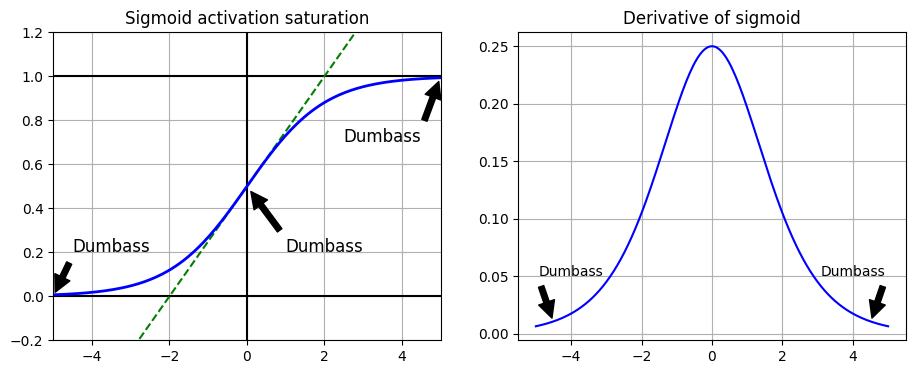

In [108]:
z = np.linspace(-5, 5, 200)
props = dict(facecolor='black', shrink=0.1)
sigmoid = lambda x: 1 / (1 + np.exp(-x))
dev_sigmoid = lambda x: sigmoid(x) * (1 - sigmoid(x))

plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot([-5, 5], [1, 1], 'k-')
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-0.75, 1.75], 'g--')
plt.plot(z, sigmoid(z), 'b-', linewidth = 2)
plt.annotate('Dumbass', xytext = (3.5, 0.7), xy = (5, 1), arrowprops=props, fontsize = 12, ha = "center")
plt.annotate('Dumbass', xytext = (-3.5, 0.2), xy = (-5, 0), arrowprops=props, fontsize = 12, ha = "center")
plt.annotate('Dumbass', xytext = (2, 0.2), xy = (0, 0.5), arrowprops=props, fontsize = 12, ha = "center")
plt.grid(True)
plt.title("Sigmoid activation saturation")
plt.axis([-5, 5, -0.2, 1.2])

plt.subplot(122)
plt.plot(z, dev_sigmoid(z), 'b-')
plt.title("Derivative of sigmoid")
plt.annotate('Dumbass', xytext = (-4, 0.05), xy = (-4.5, 0.01), arrowprops=props, fontsize = 10, ha = "center")
plt.annotate('Dumbass', xytext = (4, 0.05), xy = (4.5, 0.01), arrowprops=props, fontsize = 10, ha = "center")
plt.grid(True)
plt.show()

### Solution 1: Glorot, He, and Lecun initialization

Glorot initialization:

- $\sigma^2$ of output = $\sigma^2$ of input, and gradients need to have be equal to $\sigma^2$ before and after flowing through a layer in reverse direction to prevent vanishing/exploding gradient. But, this is not ossible unless the layer has an equal number of inputs and neurons (i.e., $\text{fan}_\text{in} = \text{fan}_\text{out}$)
- Glorot and Bengio proposed that the connection weights of each layer must be initialized randomly using the following: <br>
  1.  A normal distribution with $\mu = 0$ and $\sigma^2$ = $\displaystyle\frac{1}{\text{fan}_\text{avg}}$ <br>
  2.  A uniform distribution between $-r$ and $+r$, with $r = \displaystyle\sqrt{\frac{3}{\text{fan}_\text{avg}}}$, where $\text{fan}_\text{avg} = (\text{fan}_\text{in} + \text{fan}_\text{out}) / 2$

Other initialization methods and comparison to Glorot initialization

| Initialization |     Activation functions      |  $\sigma^2$ (Normal distribution)   |      $\pm$ r (Uniform distribution)      |
| :------------: | :---------------------------: | :---------------------------------: | :--------------------------------------: |
|     Glorot     | None, tanh, logistic, softmax |  $\displaystyle\frac{1}{\text{fan}_\text{avg}}$  | $\displaystyle\sqrt{\frac{3}{\text{fan}_\text{avg}}}$ |
|       He       |     ReLU and its variants     |  $\displaystyle\frac{2}{\text{fan}_\text{in}}$   | $\displaystyle\sqrt{\frac{6}{\text{fan}_\text{in}}}$  |
|     LeCun      |             SELU              | $\displaystyle\frac{1}{\text{fan}_\text{in}}$ \* | $\displaystyle\sqrt{\frac{3}{\text{fan}_\text{in}}}$  |

\*: preferred,

Initialization in Tensorflow:

- TF uses Glorot initialization with uniform distribution by default. Initializers are passed as an argument into the individual layers when building the model or instantiated by calling `keras.initializers.[initializer](**args)`. For example:

```python
# method 1, keyword
keras.layers.Dense(10, activation = "relu", keras_initializer = "he_normal")

# method 2, using He initialization but based on a uniform distribution w/fan_in
he_avg_init = keras.initializers.VarianceScaling(scale = 2., mode = 'fan_avg', distribution = "uniform")
keras.layers.Dense(10, activation = "relu", keras_initializer = he_avg_init)
```

- Other methods available as keyword arguments/classes, as demonstrated below:

In [185]:
initializers = [i for i in dir(keras.initializers) if not i.startswith("_") and not i[0].islower()]
(initializers, len(initializers))

(['Constant',
  'GlorotNormal',
  'GlorotUniform',
  'HeNormal',
  'HeUniform',
  'Identity',
  'Initializer',
  'LecunNormal',
  'LecunUniform',
  'Ones',
  'Orthogonal',
  'RandomNormal',
  'RandomUniform',
  'TruncatedNormal',
  'VarianceScaling',
  'Zeros'],
 16)

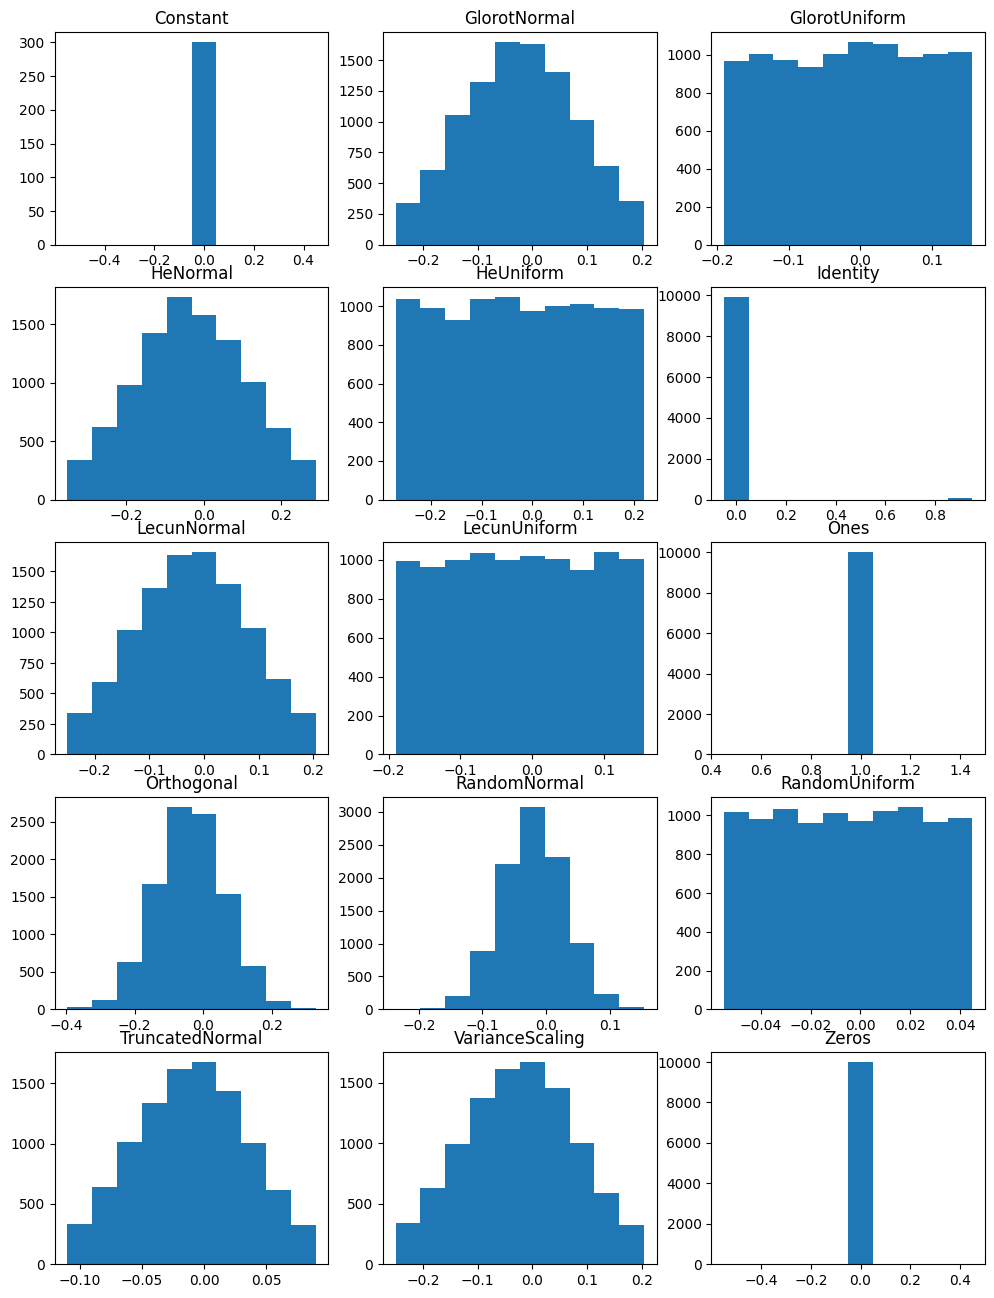

In [211]:
# construct model, each layer with a different initializer
# using default values for all 

model = keras.models.Sequential(name="initializers test")
model.add(keras.layers.InputLayer([28, 28, 3]))

for initializer in initializers:
    try: 
        initializer = getattr(keras.initializer, initializer)
        model.add(keras.layers.Dense(100, kernel_initializer = initializer()))
    except NotImplementedError: # skip Initializer class
        pass

fig, axs = plt.subplots(int(len(initializers)/3), 3, figsize = (12,16))
weight_layers = [layer for layer in model.layers if len(layer.weights) > 0]

for i, layer in enumerate(weight_layers):
    axs[int(i / 3), i % 3].hist(layer.weights[0].numpy().flatten(), align = 'left')
    axs[int(i / 3), i % 3].set_title(model.layers[i].get_config().get("kernel_initializer").get("class_name"))

### Solution 2: Non-saturating activation functions

- Problems with ReLU is that neurons can "die" (they produce 0s consistently), which causes GD to stop working effectively since the derivative of ReLU will always be zero for negative inputs.
- Variants of ReLU:<br>

  1.  LeakyReLU: $\text{max}(\alpha z, z)$<br>
      a. Randomized leaky ReLU (RReLU): The $\alpha$ in LeakyReLU is set to random in a given range during training and is set to an average value during testing. <br>
      b. Parametric leaky ReLU (PReLU): $\alpha$ can be learned during training and modifiable by backpropagation. --> usually performs better on large image datasets <br>
  2.  Exponential linear unit (ELU): Given by: <br>
      $\begin{cases}
      \alpha ( \text{exp} (z) - 1) && \text{if} z < 0 \\
      z && \text{if} z \geq 0
      \end{cases} $ <br>
      $\alpha$ defines the value ELU approaches when z is a large negative number, usually set to 1 (so output will be aroud -1) so that the function is smooth everywhere. However, ELU can be slow to compute <br>
      a. Scaled ELU: [Klambauer et al. (2017)](https://arxiv.org/pdf/1706.02515.pdf) discovered that staking dense layers with SELU, the network could self-normalize (the output of the network has a $\mu$ of 0 and $\sigma$ of 1). Self-regularization must meet the following condition: <br>
      - Input features must be standardized<br>
      - Weights must be initialized with LeCun normal initialization <br>
      - Network must be sequential and all layers must be dense.

- General rule of thumb when choosing activation functions and few other considerations: <br>
  1. In general: SELU > ELU > leaky ReLU > ReLU > tanh > logistic
  2. Few other considerations: <br>
  
     $\displaystyle\begin{cases} 
  \text{ELU > SELU} && \text{If network architecture prevents it from self-normalizing}  \\
    \text{LeakyReLU} && \text{If Runtime latency is an issue} \\
    \text{RReLU and PReLU} && \text{If there is enough computer power / data}
  \end{cases}$


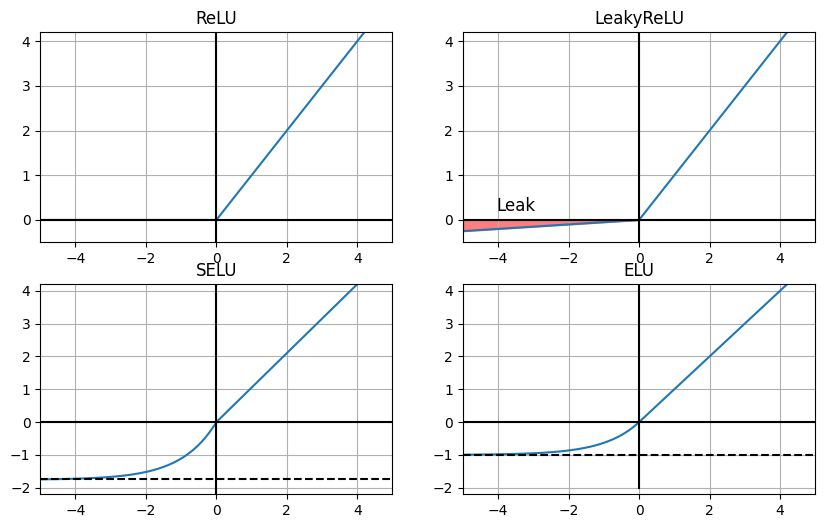

In [157]:
leaky_relu = lambda z, alpha=0.05:np.maximum(alpha * z, z)
relu = lambda z:np.maximum(0, z)
elu = lambda z, alpha=1: np.where(z < 0, alpha * (np.exp(z) - 1), z)

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
selu = lambda z, scale=scale_0_1, alpha=alpha_0_1:scale * elu(z, alpha)

plt.figure(figsize=(10,6))
plt.subplot(221) # ReLU
plt.plot(z, relu(z))
plt.plot([0,0], [-1,5], "k-");plt.plot([-5,5], [0,0], "k-")
plt.axis([-5, 5, -0.5, 4.2]); plt.grid(True)
plt.title("ReLU")

plt.subplot(222) # LeakyReLU
plt.title("LeakyReLU")
plt.plot(z, leaky_relu(z))
plt.annotate("Leak", xytext=(-3.5, 0.2), xy=(-5, 0.02), fontsize=12,ha="center")
plt.fill_between(np.linspace(-5, 0, 100), leaky_relu(z)[leaky_relu(z) < 0], color = 'red', alpha = 0.5)
plt.plot([0,0], [-1,5], "k-");plt.plot([-5,5], [0,0], "k-")
plt.axis([-5, 5, -0.5, 4.2]); plt.grid(True)

plt.subplot(223) # SELU
plt.title("SELU")
plt.plot(z, selu(z))
plt.plot(z, [min(keras.activations.selu(z))] * len(z), 'k--')
plt.plot([0,0], [-5,5], "k-");plt.plot([-5,5], [0,0], "k-")
plt.axis([-5, 5, -2.2, 4.2]); plt.grid(True)


plt.subplot(224) # ELU
plt.title("ELU")
plt.plot(z, elu(z))
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0,0], [-2,5], "k-"); plt.plot([-5,5], [0,0], "k-")
plt.axis([-5, 5, -2.2, 4.2]); plt.grid(True)

plt.show()

In [160]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print(f"Layer {layer}: mean {means:.2f}, std deviation {stds:.2f}")

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


### Solution 3: Batch normalization (BN)

- Standardizes the input to have a $\mu$ of 0 and $\sigma$ of 1, and shift the result using two paraeter vectors per layer: one for scaling and one for shifting --> lets the network learn the best scale and mean of each layer's input.
- BN considerably improves vanishing gradient problem, makes network less sensitive to weight initialization, and acts as a regulizer. 
- Algorithm:

| #   |                                        Formula                                        | Explanation                                          |
| :-- | :-----------------------------------------------------------------------------------: | :--------------------------------------------------- |
| 1   |          $\mu_B = \displaystyle\frac{1}{m_B}\sum\limits^{m_B}_{i=1}x^{(i)}$           | Vector of mean of mini-batch $B$                     |
| 2   | $\sigma_B^2 = \displaystyle\frac{1}{m_B}\sum\limits^{m_B}_{i = 1}(x^{(i)} - \mu_B)^2$ | Vector of SD of mnibatch $B$                         |
| 3   |   $\hat{x}^i = \displaystyle\frac{x^{(i)}-\mu_B}{\sqrt{(\sigma_B^2 + \epsilon)}} $    | Normalized and zero-centered inputs for instance $i$ |
| 4   |                   $z^{(i)} = \gamma \otimes \hat{x}^{(i)}  + \beta$                   | Output                                               |

$m_B$ is the number of instances in mini-batch <br>
$\gamma$ is the output scaling parameter vector of the layer (one scaling parameter per input)<br>
$\beta$ is the output shifting parameter vector of the layer (one shifting parameter per input)<br>
$\otimes$ is element-wise operation<br>
$\epsilon$ is a scaling factor (usually set to `1e-5`)

$\gamma$ and $\beta$ are learned through backpropagation, $\mu$ and $\sigma$ are estimated using exponential moving average during training and used after training - they are not affected by backpropagation, so tensorflow classify $\mu$ and $\sigma$ as "non-trainable". 

- hyperparameters: <br>
     1. Momentum: Used when updating moving averages - the layer updates the running average $\hat{v}$ given new input $v$ by: $\hat{v}\leftarrow \hat{v} \times \text{momentum} + v \times (1 - \text{momentum}) $
     2. axis: Determines the axis to be normalized, with a defult of -1 (last axis)
     
- Problems with BN: Adding model complexity. However, this can be solved by fusing BN layer with the previous layer by updating the previous layer's weights and biases so that it directly produces outputs of the appropriate scale and offset. 

In [162]:
# Implementation in keras

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(name = "BN1"),
    keras.layers.Dense(300, activation="elu", kernel_initializer = "he_normal"),
    keras.layers.BatchNormalization(name = "BN2"),
    keras.layers.Dense(100, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.BatchNormalization(name = "BN3"),
    keras.layers.Dense(10, activation = "softmax")
])

model.summary()

# To verify that mu and sigma are not trainable: 
print(f"{[(var.name, var.trainable) for var in model.layers[1].variables]}")

Model: "BN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 BN1 (BatchNormalization)    (None, 784)               3136      
                                                                 
 dense_51 (Dense)            (None, 300)               235500    
                                                                 
 BN2 (BatchNormalization)    (None, 300)               1200      
                                                                 
 dense_52 (Dense)            (None, 100)               30100     
                                                                 
 BN3 (BatchNormalization)    (None, 100)               400       
                                                                 
 dense_53 (Dense)            (None, 10)                1010     

In [164]:
# There is debate as to whether applying BN before the activation function works better. 
# The layer before BN does not need to have bias terms, which causes waste of parameters --> use_bias = False

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(name = "BN1"),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(name = "BN2"),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(name = "BN3"),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation = "softmax")
])

### Solution 4: Gradient clipping

Gradient clipping refers to the technique that clips the gradients during backpropagation so that they never exceed some threshold. There are two methods: 

- `clipvalue`: clip the partial derivative of the loss to between $\pm\text{value}$
- `clipnorm`: clips the whole gradient vector if the $\ell_2$ norm is greater than the threashold --> does not change the orientation of the gradient. 

## Working with limited data

### Solution 1: reusing pretrained layers (transfer learning)

- Transfer learning: Reuse lower layers of other network trained on other similar tasks
- This works best when the inputs have similar lower level features
- When considering using pretrained layer - <br>
     - If the tasks are similar: reuse more layers
     - 
     
     ```
      drop layers       freeze layers         unfreeze layers    add layer
     ────────────────────────amount of data──────────────────────────────► 
      few                                                           A lot     
     ```                                                                             
     
     - Reduce the learning rate
     - Fine-tune the model on new data for a few epochs before unfreezing the layers of pretrained model. 


However, transfer learning will not work well with small dense networks. 

In [3]:
def split_dataset(X, y):
     #Split the dataset into 2 sets: (Sandles, shirts) and (other)
     y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
     y_A = y[~y_5_or_6]
     y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
     y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
     return ((X[~y_5_or_6], y_A), (X[y_5_or_6], y_B))

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full, X_test = X_train_full / 255.0, X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

model_A.save("model_A.h5")

In [10]:
# build the second model
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.summary()

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 300)               235500    
                                                                 
 dense_19 (Dense)            (None, 100)               30100     
                                                                 
 dense_20 (Dense)            (None, 50)                5050      
                                                                 
 dense_21 (Dense)            (None, 50)                2550      
                                                                 
 dense_22 (Dense)            (None, 50)                2550      
                                                                 
 dense_23 (Dense)            (None, 1)                

In [15]:
# stack models (reusing pretrained weights)

model_A = keras.models.load_model("model_A.h5")
# to avoid updating both model_A and model_B, use:
# model_A_clone = keras.models.clone_model(model_A)
# model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))


# first, the layers in model_A are set to untrainable except for the last layer
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

# then, the rest of the layers in model_A are set to true
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 103ms/step - loss: 0.3258 - accuracy: 0.8550 - val_loss: 0.3718 - val_accuracy: 0.8225
Epoch 2/4
7/7 [==============================] - 0s 51ms/step - loss: 0.3127 - accuracy: 0.8550 - val_loss: 0.3595 - val_accuracy: 0.8316
Epoch 3/4
7/7 [==============================] - 0s 52ms/step - loss: 0.3015 - accuracy: 0.8700 - val_loss: 0.3471 - val_accuracy: 0.8438
Epoch 4/4
7/7 [==============================] - 0s 55ms/step - loss: 0.2901 - accuracy: 0.8750 - val_loss: 0.3355 - val_accuracy: 0.8499
Epoch 1/16
7/7 [==============================] - 1s 112ms/step - loss: 0.2548 - accuracy: 0.8900 - val_loss: 0.2634 - val_accuracy: 0.9067
Epoch 2/16
7/7 [==============================] - 0s 60ms/step - loss: 0.2024 - accuracy: 0.9300 - val_loss: 0.2242 - val_accuracy: 0.9280
Epoch 3/16
7/7 [==============================] - 0s 58ms/step - loss: 0.1707 - accuracy: 0.9550 - val_loss: 0.1971 - val_accuracy: 0.9361
Epoch 4/16
7/7 [=============

In [23]:
# verify that the stacked model performs better
print(model_B.evaluate(X_test_B, y_test_B, verbose=False))
print(model_B_on_A.evaluate(X_test_B, y_test_B, verbose=False))

[0.1018025353550911, 0.9760000109672546]
[0.07880190759897232, 0.9825000166893005]


### Solution 2: Use unsupervised learning or pretraining

- When it is costly to get labeled data, unsupervised pretraining can be performed. 
- The high level idea is to train the dataset using unsupervised methods (e.g., autoencoder, GANs) then reuse the lower layers of these networks and fine-tune the model using labeled data. 
- Unsupervised learning evolved from greedy layer-wise pretraining using restricted boltzman machines to training a large network in one shot 
- Pretraining on another auxiliary task is also a way to deal with difficulties in getting labeled data. 

## Problem: slow training process

### Solution: use faster optimizers

Basic gradient descent algorithm: $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta)$, where $\theta$ = weights, $J(\theta)$ = cost function. $\eta$ = learning rate


| Optimizer             | Equations | Description | Keras implementation |
| :-------------------- | :----------------- | :---------- | :------------------- |
| Momentum optimization | $\text{1. }m \leftarrow \beta m - \eta \nabla_\theta J(\theta)$<br>$\text{2. }\theta \leftarrow \theta + m$ | In momentum optimization, a momentum vector $m$ is introduced. This takes into account of previous gradients by subtracting the local gradient from $\beta m$ (friction * momentum) <sup>1</sup> and update the weights by adding momentum to the weight <sup>2</sup>. If the gradient remains constant, the terminal velocity is equal to $\displaystyle \frac{\eta \times \nabla_\theta J(\theta)}{(1-\beta)}$, allowing the algorithm to speed up and roll past local minima. | `keras.optimizers.SGD(lr = 0.001, momentum = 0.9)` |
| Nesterov Accelerated Gradient | $\text{1. }m \leftarrow \beta m - \eta \nabla_\theta J(\theta + \beta m)$<br>$\text{2. }\theta \leftarrow \theta + m$ | This method evaluates the gradient of the cost function ahead in the direction of the momentum, at $\theta + \beta m$. This method also helps models converge faster since it reduces the oscillations in a minima | `keras.optimizer.SGD(lr = 0.001, momentum = 0.9, nesterov=True)` | 
| Adagrad | $\text{1. } s \leftarrow s + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$<br>$\text{2. }\theta \leftarrow \theta - \eta\nabla_\theta J(\theta) \oslash \sqrt{s + \epsilon}$ | Adagrad scales down the gradient vector along the steepest dimensions to help the model converge faster. First, the square of the gradients is accumulated. The element wise computation is equivalent to $\displaystyle s_i \leftarrow s_i + \frac{\partial J(\theta)}{\partial \theta_i}^2$. If the gradient is steep along the $i^{th}$ dimention, then that dimension will get larger by iteration<sup>1</sup>. In the second step, the gradient vector is scaled down by a factor of $\sqrt{s + \epsilon}$. The second step is the vectorized form of $\displaystyle\theta_i \leftarrow \theta_i - \eta\frac{\partial J(\theta)}{\partial \frac{\theta_i}{\sqrt{s_i + \epsilon}}}.$ Therefore, this algorithm decays learning rate faster for steep dimensions, which is called _adaptive learning rate_. However, Adagrad is known for stopping too early because the learning rate gets scaled down before reaching the global minima. | `keras.optimizers.Adagrad(learning_rate=0.001)` | 
| RMSProp | $\text{1. } s \leftarrow \beta s + (1 - \beta)\nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$<br>$\text{2. }\theta \leftarrow \theta - \eta\nabla_\theta J(\theta) \oslash \sqrt{s + \epsilon}$ | RMSProp improves on Adagrad's early stopping problem by only accumulating the gradients from the most recent iteration using $\beta$ (exponential decay)<sup>1</sup>. $\beta$ is usually set to 0.9 |  `keras.optimizers.RMSProp(learning_rate=0.001, rho=0.9)`<br> (`rho` = $\beta$) |
| Adam <br> (Adaptive moment estimation) | $\displaystyle\text{1. } m \leftarrow \beta_1 m - (1 - \beta_1) \nabla_\theta J(\theta)$<br>$\displaystyle\text{2. }s \leftarrow \beta_2 s + (1 - \beta_2)\nabla_\theta J(\theta) \otimes \nabla_\theta j(\theta)$<br>$\displaystyle\text{3. } \hat{m} \leftarrow \frac{m}{1 - \beta^t_1} $<br>$\displaystyle\text{4. }\hat{s} \leftarrow \frac{s}{1 - \beta^t_2} $<br>$\text{5. }\theta \leftarrow \theta + \eta \hat{m} \oslash \sqrt{\hat{s} + \epsilon}$ | Compared to RMSProp, Adam computes the exponentially decaying averange rather than expontially decaying sum <sup>1</sup>. In step 3 and 4, $m$ and $s$ are bias-corrected moment estimates to avoid bias toward zero (since these two parameters are zero-initialized)<sup>3,4</sup>. $\beta_1$ is normally set to 0.9, and $\beta_2$ is normally set to 0.999. (Adam uses $\ell_2$ norm to scale down parameter updates)| `keras.optimizers.Adam(learning_rate =0.001, beta_1 = 0.9, beta_2 = 0.999)` | 
| AdaMax | $\displaystyle\text{1. } m \leftarrow \beta_1 m - (1 - \beta_1) \nabla_\theta J(\theta)$<br>$\displaystyle\text{2. }s \leftarrow \text{max}(\beta_2 s, \nabla_\theta J(\theta))$<br>$\displaystyle\text{3. } \hat{m} \leftarrow \frac{m}{1 - \beta^t_1} $<br>$\displaystyle\text{4. }\theta \leftarrow \theta - (\frac{\eta}{1 - \beta^t_1})\cdot\frac{m}{s}$ | In contrast to Adam, AdaMax uses $\ell_\infty$ where the parameter updates are scaled down by the max of time-decayed gradients. | `keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)` |
| Nadam | $\displaystyle\text{1. }\text{g}_t \leftarrow \nabla_{\theta_{t-1}}f(\theta_{t-1})$<br>$\displaystyle\text{2. }\hat{g} \leftarrow \frac{g_t}{1 - \prod^{t}_{i = 1}\mu_i}$<br>$\displaystyle\text{3. }m_t \leftarrow \mu m_{t-1} + (1 - \mu) g_t$<br>$\displaystyle\text{4. }\hat{m}_t \leftarrow \frac{m_t}{1 - \prod^{t + 1}_{i = 1}\mu_i}$<br>$\displaystyle\text{5. }n_t \leftarrow \mathbb{v}n_{t-1} + (1 - v) g^2_t$<br>$\displaystyle\text{6. }\hat{n}_t \leftarrow \frac{n_t}{1 - \mathbb{v}^t}$<br>$\displaystyle\text{7. }\bar{m}_t \leftarrow (1 - \mu_t) \hat{g}_t + \mu_{t+1} \hat{m}_t$<br>$\displaystyle\text{8. }\theta_t \leftarrow \theta_{t-1} - \eta \frac{\bar{m}_t}{\sqrt(\hat{n}_t)+\epsilon}$ | Adam + nesterov, and therefore converges faster than Adam. Notation convention in the equations on the left is different from the ones used in the HOML book and is listed as follows: $\mu$ = $\beta_1$, $t$ = time step, $\mathbb{v}$ = $\beta_2$ | `keras.optimizers.Nadam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)` | 
| AdamW | $\displaystyle\text{1. } m \leftarrow \beta_1 m - (1 - \beta_1) \nabla_\theta J(\theta)$<br>$\displaystyle\text{2. }s \leftarrow \beta_2 s + (1 - \beta_2)\nabla_\theta J(\theta) \otimes \nabla_\theta j(\theta)$<br>$\displaystyle\text{3. } \hat{m} \leftarrow \frac{m}{1 - \beta^t_1} $<br>$\displaystyle\text{4. }\hat{s} \leftarrow \frac{s}{1 - \beta^t_2} $<br>$\text{5. }\theta \leftarrow \theta + \eta \hat{m} \oslash \sqrt{\hat{s} + \epsilon} + \lambda \theta_{t-1}$| Decouples weight decay from the optimization step.  | `keras.optimizers.AdamW(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)` |


### Comparison of optimizers: 
| Optimizer | Speed | Quality | 
|:----|:-----|:-----|
|SGD| `*` | `***` |
|SGD with momentum| `**` | `***` |
|SGD with nesterov and momentum| `**` | `***` |
|Adagrad| `*` | `*` |
|RMSProp| `*` | `***` |
|Adam| `*` | `***` |
|Nadam| `*` | `***` |
|Adamax| `*` | `***` |


### Solution 2: Use different learning rate schedulers
| Scheduling technique | Definition  | Caveats |
|:----|:-----|:-----|
| Power scheduling | Set learning rate to a function of the interation number $t$: $\displaystyle\eta(t) = \frac{\eta_0}{1 + \frac{t}{s}^c}$. $s$ is step, $c$ is usually set to 1, and $t$ is the iteration number.  | Requires tuning $\eta_0$, $c$ and $s$ |
| Exponential scheduling | lr = $\displaystyle\eta(t) = \eta_0 0.1^{\frac{t}{s}}$| |
| Piecewise constant scheduling | Use a constant lr for a number of epochs and switch to a smaller lr for another number of epochs. | Might need extra tuning to figure out the right number of lr and number of epochs at which the lr will be kept. |
| Performance scheduling | Measure a given value for $N$ steps and reduce lr by a factor $\lambda$ if the measure does not improve| | 
| 1cycle scheduling | The lr starts from $\eta_0$ and grows to $\eta_1$ half way through training, and goes back down to $\eta_0$ by the end of training. $\eta_1$ can be chosen by the lr exponentially-increasing lr method. Momentum is brought from high to low during the first half of the training, and then brought back up during the second half of the training.  | |

2023-06-24 02:07:05.862744: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


430/430 [==============================] - 5s 11ms/step - loss: nan - accuracy: 0.5473


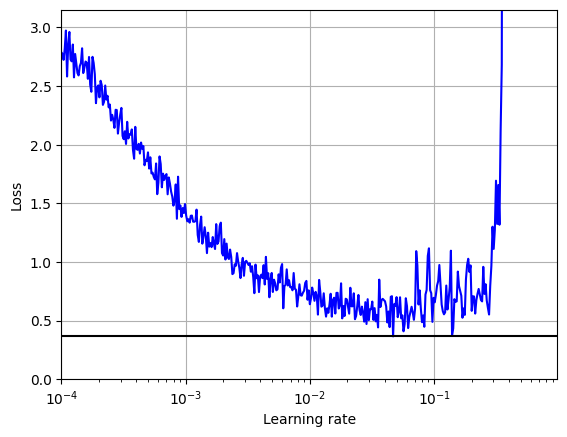

In [20]:
n_epochs = 25
lr = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = lr / (1 + decay * epochs * n_steps_per_epoch)

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

def org_model():
    model = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[28, 28]),
            keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
            keras.layers.Dense(10, activation="softmax")
        ])
    return model 

def exponential_decay_fn(epoch):
    return 0.01 * 0.1** (epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch <= 15:
        return 0.005
    else:
        return 0.001 
    
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn


class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s = 40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.01**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {} 
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

class ExponentialLR(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0
        
    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)
        
def find_lr(model, X, y, epochs = 1, batch_size = 32, min_rate = 1e-4, max_rate = 1):
    try: 
        init_weights = model.get_weights()
        iterations = math.ceil(len(X) / batch_size) * epochs
        factor = (max_rate / min_rate) ** (1 / iterations)
        init_lr = K.get_value(model.optimizer.learning_rate)
        K.set_value(model.optimizer.learning_rate, min_rate)
        exp_lr = ExponentialLR(factor)
        history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                            callbacks=[exp_lr])
        K.set_value(model.optimizer.learning_rate, init_lr)
        model.set_weights(init_weights)
        return exp_lr.rates, exp_lr.losses
    except AttributeError:
        print("compile the model first")

def plot_lr_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

keras.backend.clear_session()
model = org_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
batch_size = 128
rates, losses = find_lr(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_loss(rates, losses)

In [98]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0
        self.lr_record = []

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)
        self.lr_record.append(lr)

In [ ]:
# power scheduling, output redacted
power_model = org_model()
power_model.compile(loss="sparse_categorical_crossentropy", 
                    optimizer=keras.optimizers.SGD(learning_rate=0.01, decay = 1e-4),
                    metrics=["accuracy"])
pow_history = power_model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose = 2)

In [ ]:
#exponential decay , output redacted
exp_model = org_model()
exponential_decay_fn = exponential_decay(lr0 = 0.01, s = 20)
exp_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
exp_history = exp_model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler],
                    verbose = 2)

In [ ]:
# exponential decay with learning rate update at each iteration, output redacted
exp_iter_model = org_model()
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
exp_iter_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
exp_decay = ExponentialDecay(20 * len(X_train) // 32) # number of steps in 20 epochs (batch size = 32)
exp_iter_history = exp_iter_model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay],
                    verbose = 2)

In [ ]:
# piecewise constant, output redacted
piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
pw_model = org_model()
pw_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
piecewise_history = pw_model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler],
                    verbose = 2)

In [ ]:
# performance scheduling, output redacted
perf_model = org_model()
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
perf_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
perf_history = perf_model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler],
                    verbose = 2)

In [ ]:
# one_cycle, output redacted
oc_model = org_model()
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_lr=0.05)
oc_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
onecycle_history = oc_model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle],
                    verbose = 2)

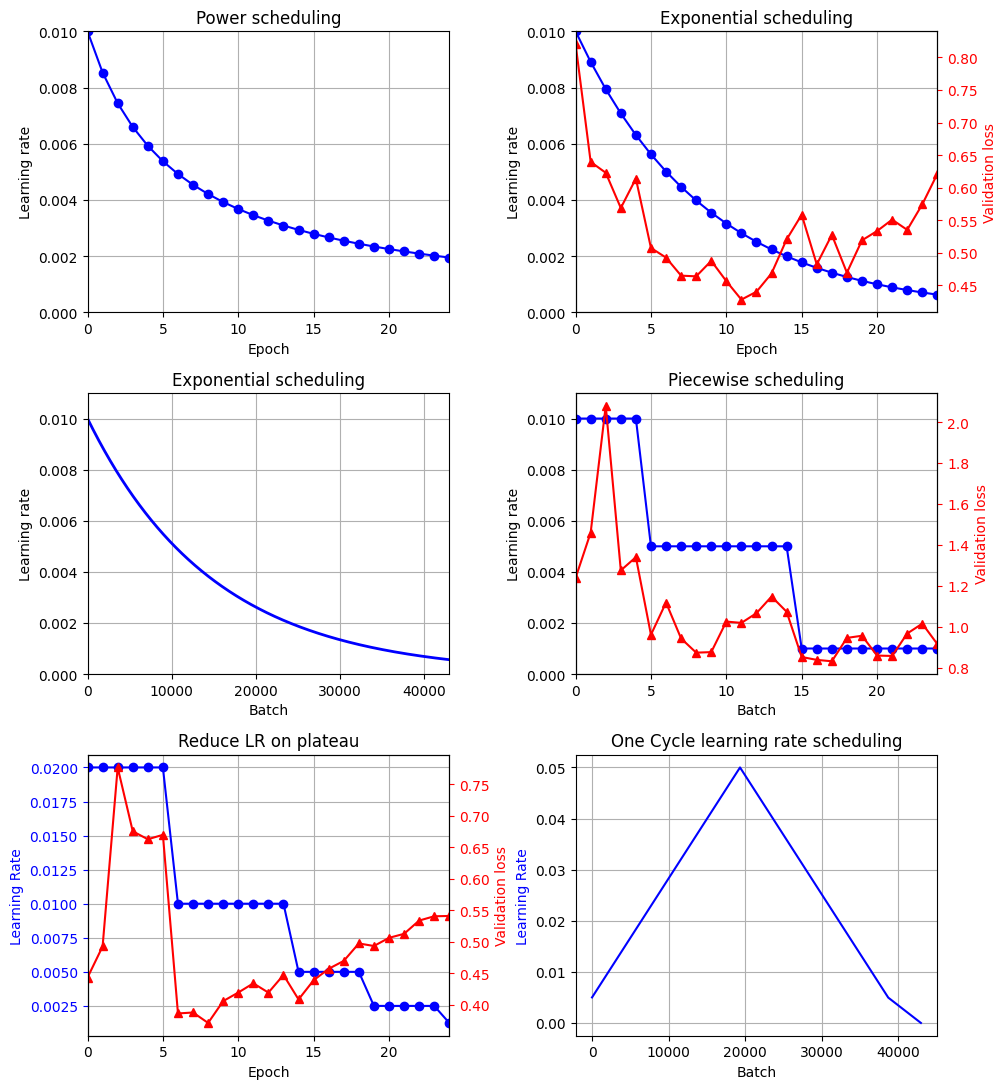

In [122]:
# visualize lr schedulers 
n_epochs = 25
lr = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = lr / (1 + decay * epochs * n_steps_per_epoch)

# power scheduling
plt.figure(figsize=(10, 11))
plt.subplot(321)
plt.plot(epochs, lrs, "bo-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Power scheduling")
plt.grid(True)

# exponential scheduling
plt.subplot(322)
plt.plot(exp_history.epoch, exp_history.history['lr'], 'bo-')
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Exponential scheduling")
plt.grid(True)
ax2 = plt.gca().twinx()
ax2.plot(exp_history.epoch, exp_history.history['val_loss'], "r^-")
ax2.set_ylabel("Validation loss", color = "r")
ax2.tick_params('y', colors = "r")

# Exponential scheduling per batch 
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lr0 = 0.01
s = 20 * len(X_train) // 32
lrs = lr0 * 0.1**(steps / s)
plt.subplot(323)
plt.plot(steps, lrs, "b-", linewidth=2,)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning rate")
plt.title("Exponential scheduling")
plt.grid(True)

# piecewise
plt.subplot(324)
plt.plot(piecewise_history.epoch, piecewise_history.history['lr'], 'bo-')
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Batch")
plt.ylabel("Learning rate")
plt.title("Piecewise scheduling")
plt.grid(True)
ax2 = plt.gca().twinx()
ax2.plot(piecewise_history.epoch, piecewise_history.history['val_loss'], "r^-")
ax2.set_ylabel("Validation loss", color = "r")
ax2.tick_params('y', colors = "r")

# performance scheduling 
plt.subplot(325)
plt.plot(perf_history.epoch, perf_history.history['lr'], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params("y", colors = "b")
plt.gca().set_xlim(0, n_epochs-1)
plt.grid(True)
ax2 = plt.gca().twinx()
ax2.plot(perf_history.epoch, perf_history.history['val_loss'], "r^-")
ax2.set_ylabel("Validation loss", color = "r")
ax2.tick_params('y', colors = "r")
plt.title("Reduce LR on plateau")

plt.subplot(326)
plt.plot(np.arange(0,onecycle.iteration), onecycle.lr_record, "b-")
plt.xlabel("Batch")
plt.ylabel("Learning Rate", color='b')
plt.grid(True)
plt.title("One Cycle learning rate scheduling")
plt.tight_layout()

Another way to implement learning rate scheduling is through predefined schedulers in `keras.optimizers.schedules` 

In [126]:
[i for i in dir(keras.optimizers.schedules) if i[0].isupper()]

['CosineDecay',
 'CosineDecayRestarts',
 'ExponentialDecay',
 'InverseTimeDecay',
 'LearningRateSchedule',
 'PiecewiseConstantDecay',
 'PolynomialDecay']

## Problem: Overfitting

### Solution 1: Regularizations - $\ell_1$ and $\ell_2$ regularization

- Batch normalization adn early stopping already act as decent regulizers, but there are also other options like $\ell_1$ and $\ell_2$ regularization. 
     - $ell_1$: sparse model, $ell_2$: constrain connection weights
     - Implementation: through `keras.regularizers`, which contains `l1()`, `l2()`, and `l1_l2()`.

In [ ]:
# a quick trick to avoid repeating the same argument
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation = "elu",
                           kernel_initializer = "he_normal",
                           kernel_regularizer = keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layer.Flatten(input_shape = [28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation = "softmax", kernel_initializer = "glorot_uniform")
])

### Solution 2: Regularization - Dropout

In dropout, each neuron has a probability $p$ of being ignored in a training step. This works because neurons are forced to avoid co-adapting with their neighboring neurons, and therefore less sensible to changes in the inputs and therefore giving better generalization performance. 

Since dropout affects the number of inbound connection that a neuron takes, a "keep probability" needs to be multiplied to connection weights after training ($1-p$), or alternatively divide connection weights by $p$ during training. 

Implementing dropouts in keras: adding the `keras.layers.Dropout(rate)` to the model, with rate = 0.2 - 0.3 in recurrent networks, and 0.4-0.5 in CNNs. If implementing self-normalizing network with SELU, use alpha dropout `keras.layers.AlphaDropout(rate)`. 

Another dropout method, Monte Carlo dropout, is easy to implement and reduces regular dropout's uncertainty. 

In [194]:
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=512,
                    validation_data=(X_valid_scaled, y_valid))

# Monte carlo dropout 
# training=True to let dropout layer remain active. make 100 predictions
y_probs = np.stack([model(X_test_scaled, training = True) for sample in range(100)])
print(f"y_probs shape: {y_probs.shape} --> ((num_predictions, samples, class_probs))")
# average over the 0 axis --> average each prediction
y_prob = y_probs.mean(axis = 0)

Epoch 1/10
108/108 [==============================] - 2s 18ms/step - loss: 0.9882 - accuracy: 0.6523 - val_loss: 0.7272 - val_accuracy: 0.8112
Epoch 2/10
108/108 [==============================] - 1s 14ms/step - loss: 0.6338 - accuracy: 0.7709 - val_loss: 0.6465 - val_accuracy: 0.8300
Epoch 3/10
108/108 [==============================] - 1s 13ms/step - loss: 0.5740 - accuracy: 0.7934 - val_loss: 0.6235 - val_accuracy: 0.8396
Epoch 4/10
108/108 [==============================] - 1s 13ms/step - loss: 0.5352 - accuracy: 0.8069 - val_loss: 0.5902 - val_accuracy: 0.8468
Epoch 5/10
108/108 [==============================] - 1s 13ms/step - loss: 0.5122 - accuracy: 0.8157 - val_loss: 0.6001 - val_accuracy: 0.8510
Epoch 6/10
108/108 [==============================] - 1s 13ms/step - loss: 0.4973 - accuracy: 0.8221 - val_loss: 0.5820 - val_accuracy: 0.8528
Epoch 7/10
108/108 [==============================] - 1s 14ms/step - loss: 0.4822 - accuracy: 0.8277 - val_loss: 0.5780 - val_accuracy: 0.8538

In [195]:
print(f"{'*'* 10} With dropout off {'*'* 10}")
print(np.round(model.predict(X_test_scaled[:1],verbose=False), 2))
print(f"\n{'*'* 10} With dropout on {'*'* 10}")
print(np.round(y_prob[0], 2))
print(f"\n{'*'* 10} SD of model w/dropout {'*'* 10}")
y_std = y_probs.std(axis = 0)
print(np.round(y_std[0],3))
print(f"\n{'*'* 10} Accuracy {'*'* 10}")
y_pred = y_prob.argmax(axis = 1)
acc = np.sum(y_pred == y_test) / len(y_test)
print(acc)

********** With dropout off **********
[[0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.98]]

********** With dropout on **********
[0.   0.   0.   0.   0.   0.18 0.   0.29 0.01 0.51]

********** SD of model w/dropout **********
[0.    0.    0.    0.    0.    0.204 0.    0.248 0.029 0.27 ]

********** Accuracy **********
0.8398


In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        # Implement MCDropout by forceing training = True
        return super().call(inputs, training = True)

### Solution 3: Regularization (Max-norm regularization) 

Max-norm regularization constraints the weights of incoming connections such that $||w||_2 \leq r$, where $r$ is a hyperparameter and $||\cdot||_2$ is the $\ell_2$ norm

This algorithm only computes and rescales $w$ if needed after each training step: $w \leftarrow w \frac{r}{||w||_2}$. Reducing $r$ increases the regularization. Keras implementation is as follows: 

```python
keras.layers.Dense(100, activation = "elu", kernel_initializer = "he_normal",
                   kernel_constraint = keras.constraints.max_norm(1.))
```

`kerne_constraint` is customizable. 
`axis` is set to 0 by default, and will need to be modified in CNNs. 

## Conclusion:

Some defaults to consider for DNNs:

| Hyperparam          | Default DNN                          | Self-normalizing net    |
| :------------------ | :----------------------------------- | :---------------------- |
| Kernel initializer  | He initialization                    | LeCun initialization    |
| Activation function | ELU                                  | SELU                    |
| Normalization       | Apply batch norm if deep             | None                    |
| Regularization      | Early stopping (+$\ell_2$ if needed) | Alpha dropout if needed |
| Optimizer           | RMSProp or Nadam                     | RMSProp or Nadam        |
| LR schedule         | 1cycle                               | 1cycle                  |

Some other considerations:
1. Sparse model: use $\ell_1$ regularization
2. Low-latency model: Use computationally inexpensive activation functions (e.g., leaky ReLU), fold batch norm into previous layers, and reduce fp precision
3. Risk sensitive: Use MCDropout 

## Exercises
1. No. Initializing weights to the same value can make it difficult for backpropagation to break the symmetry of weights. 
2. Yes. 
3. 1) self-normalizing, 2) Output is closer to 0 than ReLU, 3) differentiable under 0
4. SELU --> slef normalizing in certain condition. For speed, use ReLU, leaky ReLU, and its variants. tanh for output w/range (-1, 1). Logistic for the probability of classes in binary classification tasks, and softmax for the probability of classes in multi-class classification tasks. 
5. May take longer for NN to converge 
6. Zero all tiny weights, use $\ell_1$ regularization, or use tensorflow optimization module. 
7. SELU --> slef normalizing in certain condition. 
8. see code cell below

In [36]:
# a & b
K.clear_session()
(X_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
X_train, x_val, y_train, y_val = X_train[5000:], X_train[:5000], y_train[5000:], y_train[:5000]

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
for i in range(20):
    model.add(keras.layers.Dense(100, activation = "elu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(optimizer = "nadam",
              metrics=['accuracy'],
              loss="sparse_categorical_crossentropy")
rates, losses = find_lr(model=model, X=X_train, y=y_train, epochs = 1, batch_size = 256, min_rate = 1e-5) # increased batchsize for speed

176/176 [==============================] - 21s 92ms/step - loss: 12946598019465216.0000 - accuracy: 0.1055


(1e-05, -156766306304.0)

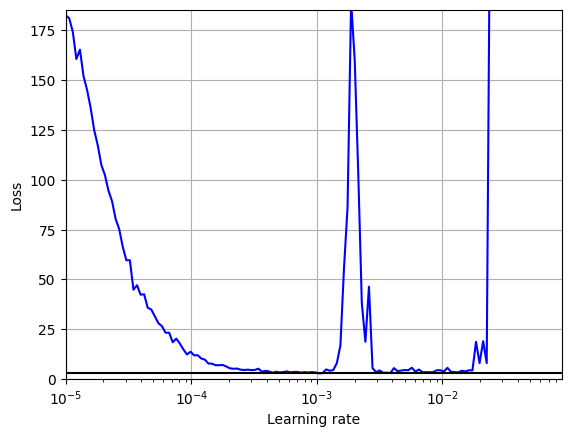

In [46]:
n = 140
plot_lr_loss(rates=rates[:n], losses=losses[:n])

In [ ]:
optim = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy'],
              optimizer=optim)

early_stopping = keras.callbacks.EarlyStopping(patience = 20)
org_history = model.fit(X_train, y_train, epochs = 100, 
                        validation_data = (x_val, y_val),
                        callbacks=[early_stopping], batch_size=512)

# output redacted

In [48]:
model.evaluate(x_val, y_val)

157/157 [==============================] - 4s 24ms/step - loss: 1.6696 - accuracy: 0.3918


[1.6695976257324219, 0.3917999863624573]

In [ ]:
# c
K.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
for i in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

optim = keras.optimizers.Nadam(learning_rate=1e-3)
early_stopping = keras.callbacks.EarlyStopping(patience=20)
model.compile(loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy'],
              optimizer=optim)
bn_history = model.fit(X_train, y_train, epochs = 100, 
                        validation_data = (x_val, y_val),
                        callbacks=[early_stopping], batch_size=512)

In [52]:
model.evaluate(x_val, y_val)

157/157 [==============================] - 5s 31ms/step - loss: 2.3505 - accuracy: 0.4540


[2.3504862785339355, 0.45399999618530273]

In [68]:
K.clear_session()

In [ ]:
K.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
for i in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal",activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optim = keras.optimizers.Nadam(learning_rate = 1e-3)
early_stopping = keras.callbacks.EarlyStopping(patience=20)

model.compile(loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy'],
              optimizer=optim)

mean = X_train.mean(axis = 0, keepdims=True)
std = X_train.std(axis = 0, keepdims=True)

X_train_s = (X_train - mean) / std
x_val_s = (x_val - mean) / std
x_test_s = (x_test - mean) / std

sn_history = model.fit(X_train_s, y_train, epochs = 100, 
                        validation_data = (x_val_s, y_val),
                        callbacks=[early_stopping])

In [ ]:
model.evaluate(x_val_s, y_val)